In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import model_torch as model
import numpy as np
from model_torch import *
from siamese_train import *
# utils函数暂时只用到了utils的noise

In [2]:
import cwru   #读取数据集
window_size = 2048
data = cwru.CWRU(['12DriveEndFault'], ['1730','1750','1772'], window_size)

Datasets/CWRU 12DriveEndFault 1772
0 Datasets/CWRU/NormalBaseline/1730/Normal.mat
(485643, 2)
1 Datasets/CWRU/NormalBaseline/1750/Normal.mat
dict_keys(['__header__', '__version__', '__globals__', 'ans', 'X098_DE_time', 'X098_FE_time', 'X099_DE_time', 'X099_FE_time'])
(483903, 2)
2 Datasets/CWRU/NormalBaseline/1772/Normal.mat
(483903, 2)
3 Datasets/CWRU/12DriveEndFault/1730/0.007-Ball.mat
(121556, 2)
4 Datasets/CWRU/12DriveEndFault/1750/0.007-Ball.mat
(121556, 2)
5 Datasets/CWRU/12DriveEndFault/1772/0.007-Ball.mat
(121410, 2)
6 Datasets/CWRU/12DriveEndFault/1730/0.014-Ball.mat
(122136, 2)
7 Datasets/CWRU/12DriveEndFault/1750/0.014-Ball.mat
(121991, 2)
8 Datasets/CWRU/12DriveEndFault/1772/0.014-Ball.mat
(122136, 2)
9 Datasets/CWRU/12DriveEndFault/1730/0.021-Ball.mat
(122136, 2)
10 Datasets/CWRU/12DriveEndFault/1750/0.021-Ball.mat
(122136, 2)
11 Datasets/CWRU/12DriveEndFault/1772/0.021-Ball.mat
(121701, 2)
12 Datasets/CWRU/12DriveEndFault/1730/0.007-InnerRace.mat
(122917, 2)
13 Datasets/C

In [3]:
set(data.y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [4]:
from scipy.fftpack import fft

data.X_train=fft(data.X_train).real
data.X_test=fft(data.X_test).real

In [5]:
snrs = [-4,-2,0,2,4,6,8,10,None]  # 噪音的程度


settings = {              # 设置参数
  "N_way": 10,           # how many classes for testing one-shot tasks>
  "batch_size": 32,
  "best": -1,
  "evaluate_every": 200,   # interval for evaluating on one-shot tasks
  "loss_every": 200,      # interval for printing loss (iterations)
  "n_iter": 15000,
  "n_val": 2,          #how many one-shot tasks to validate on?
  "n": 0,
  "save_path":"",       #存储空间，空的字符串，后面赋值
  "save_weights_file": "weights-best-model.pkl"
}

exp_name = "EXP-AB"     #实验名称
# exps = [60,90,120,200,300,600,900,1500,3000,6000,12000,19800]
exps = [60,90,120,200,300,600,900,] #1500,6000,19800]
# exps = [60,90,120]
times = 1


In [6]:
from cwru import *
import utils
from utils import *

is_training = not False   # enable or disable train models. if enable training, save best models will be update.

def EXPAB_train_and_test(exp_name,exps,is_training):
    train_classes = sorted(list(set(data.y_train)))  # 数据集类别 0 - 9
    train_indices = [np.where(data.y_train == i)[0] for i in train_classes] #数据集下标，有10行，第一行类别为0的下标，所有的类别为i的下标
    
    for exp in exps:
        scores_1_shot = []
        scores_5_shot = []
        scores_5_shot_prod = []
        scores_wdcnn = []
        # 每次挑选num个数据进行训练
        num = int(exp/len(train_classes))
        settings['evaluate_every'] = 300 if exp<1000 else 600  #每300次做一个模型的评估，每训练300次，做一次评估，一共训练15000次（未考虑early stop）
        #print(settings['evaluate_every'])
        for time_idx in range(times):
            seed = int(time_idx/4)*10    #作者自己定的
            np.random.seed(seed)          # 取得随机数是一样的， 80-82可以删掉？
            print('random seed:',seed)     
            print("\n%s-%s"%(exp,time_idx) + '*'*80)
            settings["save_path"] = "tmp/%s/size_%s/time_%s/" % (exp_name,exp,time_idx)
            data._mkdir(settings["save_path"])
            train_idxs = []  # 训练数据下标
            val_idxs = []   # 评估数据下标
            for i, c in enumerate(train_classes):
                select_idx = train_indices[i][np.random.choice(len(train_indices[i]), num, replace=True)]
                split = int(0.6*num)   # 文章里面写的Other methods use 60% samples as the training set and the rest samples as the validation set
                train_idxs.extend(select_idx[:split])   #六成是训练，四成是测试，例：60个数据里六成是训练，一般是六四，七三，八二
                val_idxs.extend(select_idx[split:])      # extend 几个列表合并
            X_train, y_train = data.X_train[train_idxs],data.y_train[train_idxs],   #通过下标取出训练集
            X_val, y_val = data.X_train[val_idxs],data.y_train[val_idxs],

            # load one-shot model and training

            # 训练SiameseNet   开始训练
            if(is_training):
                siamese_net = model.SiameseNet(2)
                net = siamese_net.cuda() #定义模型且移至GPU
                criterion = nn.BCELoss() #定义损失函数 binary_crossentropy
                optimizer = optim.Adam(net.parameters(), lr = 0.0005) #定义优化器
                siamese_dataset = SiameseNetworkDataset(X_train, y_train, X_val, y_val)   #读取数据集
                train_dataloader = DataLoader(siamese_dataset,     #转化成torch可以用的
                                            shuffle=True,
                                            batch_size=1)
#                 print(next(iter(train_dataloader)))
                siamese_dataset_val = SiameseNetworkDataset(X_train, y_train, X_val, y_val, mode='test')

                test_dataloader = DataLoader(siamese_dataset_val,
                                            shuffle=False,
                                            batch_size=1)
                settings['save_weights_file'] = 'siamese_best_model.pkl'       # 模型保存
                
                print(train_and_test_oneshot(net, optimizer, criterion, train_dataloader, test_dataloader, settings))    # 开始训练


            # load wdcnn model and training
            # y_train = torch.eye(data.nclasses)[y_train,:]
            # y_val = torch.eye(data.nclasses)[y_val,:]
            # y_test = torch.eye(data.nclasses)[data.y_test,:]

            # 训练WDCNN
            if(is_training):
                wdcnn_net = WDCNN()

                settings['save_weights_file'] = 'wdcnn_best_model.pkl'
                wdcnn_train_data = WDCNNDataset(X_train, y_train)           #读取数据集
                wdcnn_train_dataloader = DataLoader(wdcnn_train_data,
                                            shuffle=True,
                                            batch_size=32)
                wdcnn_val_data = WDCNNDataset(X_val, y_val)
                wdcnn_val_dataloader = DataLoader(wdcnn_val_data,
                                            shuffle=True,
                                            batch_size=32)
                wdcnn_net = wdcnn_net.cuda() #定义模型且移至GPU
                wdcnn_criterion = nn.CrossEntropyLoss() #定义损失函数 crossentropy
                wdcnn_optimizer = optim.Adam(wdcnn_net.parameters(), lr = 0.0005) #定义优化器
                settings['n_iter'] = 300
                train_and_test_oneshot2(wdcnn_net, wdcnn_optimizer, wdcnn_criterion, wdcnn_train_dataloader, wdcnn_val_dataloader, settings)


            # loading best weights and testing
            wdcnn_net = WDCNN().cuda()
            siamese_net = model.SiameseNet(2).cuda()
            
            wdcnn_net.load_state_dict(torch.load(settings["save_path"] + 'wdcnn_best_model.pkl'))      # 加载最好的model
            siamese_net.load_state_dict(torch.load(settings["save_path"] + 'siamese_best_model.pkl'))
            for snr in snrs:                  # 加噪声，干扰.其余的干扰包括 图片加雪花点/把图片扣掉一部分
                print("\n%s_%s_%s"%(exp,time_idx,snr) + '*'*80)
                X_test_noise = []              #考虑噪声影响
                if snr != None:
                    for x in data.X_test:
                        X_test_noise.append(utils.noise_rw(x,snr))
                    X_test_noise = np.array(X_test_noise)
                else:
                    X_test_noise = data.X_test


                # test 1_shot and 5_shot
                net = siamese_net.cuda() #定义模型且移至GPU

                siamese_dataset_val = SiameseNetworkDataset(X_train, y_train, X_test_noise, data.y_test, mode='test')

                val_dataloader = DataLoader(siamese_dataset_val,
                                            shuffle=False,
                                            batch_size=1)


                preds_5_shot = []
                prods_5_shot = []
                scores = []


                for k in range(5):   # 需要修改5，重复5次oneshot，论文里面原话：We repeat one-shot K-way testing five times as the five-shot data support set while each time the data support set S is randomly selected from the training data.
                    # Supportset每次都不一定一样
                    preds = []
                    probs_all = []
                    n_correct = 0
                    N,w,h = len(set(data.y_test)), 2, 2048
                    for i, batch_data in enumerate(val_dataloader, 0):
                        input0, input1, label, label0, label1 = batch_data
                        support_set = input0.reshape(input0.shape[1:]).cuda()
                        batch_input = input1.reshape(input1.shape[1:]).cuda()

                        predict = net(batch_input,support_set)
                        # print(predict, labels)
                        # print(predict)
                        if np.argmax(predict.cpu().detach().numpy()) == label0:
                            n_correct+=1
                        preds.append([label0, np.argmax(predict.cpu().detach().numpy())])
#                         print('predict', np.argmax(predict.cpu().detach().numpy()))
                        probs_all.append(predict.cpu().detach().numpy())
                    percent_correct = (100.0*n_correct / len(data.y_test))
                    print("Got an average of {}% {} way one-shot accuracy".format(percent_correct,N))

                    preds = np.array(preds)
                    prods = np.array(probs_all)
                    #print(percent_correct, preds.shape, prods.shape)
                    scores.append(percent_correct)
                    preds_5_shot.append(preds[:, 1])
                    prods_5_shot.append(prods)
                preds = []
                for line in np.array(preds_5_shot, dtype='int64').T:
                    preds.append(np.argmax(np.bincount(line)))
    #             utils.confusion_plot(np.array(preds),data.y_test)
                prod_preds = np.argmax(np.sum(prods_5_shot,axis=0),axis=1).reshape(-1)
                print(prod_preds.shape)
                score_5_shot = accuracy_score(data.y_test,np.array(preds))*100
                print('5_shot:',score_5_shot)

                score_5_shot_prod = accuracy_score(data.y_test,prod_preds)*100
                print('5_shot_prod:',score_5_shot_prod)

                scores_1_shot.append(scores[0])
                scores_5_shot.append(score_5_shot)
                scores_5_shot_prod.append(score_5_shot_prod)

                # test wdcnn
                predict = wdcnn_net(torch.from_numpy(np.array(X_test_noise, dtype='float32')).cuda())
                predict = predict.cpu().detach().numpy()
                predict = [np.argmax(i) for i in predict]        # one hot编码， argmax把真实类别取出来
                score = accuracy_score(predict, data.y_test)*100
                print('wdcnn:', score)
                scores_wdcnn.append(score)


        a =pd.DataFrame(np.array(scores_1_shot).reshape(-1,len(snrs)))
        a.columns = snrs
        a.to_csv("tmp/%s/size_%s/scores_1_shot.csv" % (exp_name,exp),index=True)

        a =pd.DataFrame(np.array(scores_5_shot).reshape(-1,len(snrs)))
        a.columns = snrs
        a.to_csv("tmp/%s/size_%s/scores_5_shot.csv" % (exp_name,exp),index=True)

        a =pd.DataFrame(np.array(scores_5_shot_prod).reshape(-1,len(snrs)))
        a.columns = snrs
        a.to_csv("tmp/%s/size_%s/scores_5_shot_prod.csv" % (exp_name,exp),index=True)

        a =pd.DataFrame(np.array(scores_wdcnn).reshape(-1,len(snrs)))
        a.columns = snrs
        a.to_csv("tmp/%s/size_%s/scores_wdcnn.csv" % (exp_name,exp),index=True)


EXPAB_train_and_test(exp_name,exps,is_training)

random seed: 0

60-0********************************************************************************
training...
Epoch number: 0 , i: 0, Current loss: 0.6936

0 : 0.69363,

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([1, 10])) that is different to the input size (torch.Size([10, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



iteration 29 evaluating: 0.3

Epoch number: 1 , i: 0, Current loss: 0.6960

0 : 0.69599,
iteration 29 evaluating: 0.43333333333333335

Epoch number: 2 , i: 0, Current loss: 0.6552

0 : 0.65518,Epoch number: 3 , i: 0, Current loss: 0.5996

0 : 0.59963,Epoch number: 4 , i: 0, Current loss: 0.4879

0 : 0.48791,EarlyStopping counter: 1 out of 20
Epoch number: 5 , i: 0, Current loss: 0.4527

0 : 0.45266,Epoch number: 6 , i: 0, Current loss: 0.2851

0 : 0.28507,EarlyStopping counter: 1 out of 20
Epoch number: 7 , i: 0, Current loss: 0.5078

0 : 0.50784,EarlyStopping counter: 2 out of 20
Epoch number: 8 , i: 0, Current loss: 0.3668

0 : 0.36677,Epoch number: 9 , i: 0, Current loss: 0.3079

0 : 0.30788,EarlyStopping counter: 1 out of 20
Epoch number: 10 , i: 0, Current loss: 0.3510

0 : 0.35095,Epoch number: 11 , i: 0, Current loss: 0.3398

0 : 0.33982,EarlyStopping counter: 1 out of 20
Epoch number: 12 , i: 0, Current loss: 0.5244

0 : 0.52436,Epoch number: 13 , i: 0, Current loss: 0.1685

0

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch number: 7 , i: 0, Current loss: 2.2937, acc :0.1333

0 : 2.29373,Epoch number: 8 , i: 0, Current loss: 2.2899, acc :0.1333

0 : 2.28989,Epoch number: 9 , i: 0, Current loss: 2.2910, acc :0.1000

0 : 2.29101,Epoch number: 10 , i: 0, Current loss: 2.2946, acc :0.1333

0 : 2.29465,Epoch number: 11 , i: 0, Current loss: 2.2812, acc :0.1333

0 : 2.28117,Epoch number: 12 , i: 0, Current loss: 2.2887, acc :0.1000

0 : 2.28869,Epoch number: 13 , i: 0, Current loss: 2.2850, acc :0.1000

0 : 2.28498,Epoch number: 14 , i: 0, Current loss: 2.2724, acc :0.1000

0 : 2.27242,Epoch number: 15 , i: 0, Current loss: 2.2685, acc :0.1000

0 : 2.26852,Epoch number: 16 , i: 0, Current loss: 2.2781, acc :0.1000

0 : 2.27815,Epoch number: 17 , i: 0, Current loss: 2.2633, acc :0.1000

0 : 2.26326,Epoch number: 18 , i: 0, Current loss: 2.2788, acc :0.1000

0 : 2.27885,Epoch number: 19 , i: 0, Current loss: 2.2821, acc :0.1000

0 : 2.28205,Epoch number: 20 , i: 0, Current loss: 2.2655, acc :0.1000

0 : 2.2

0 : 1.77705,EarlyStopping counter: 1 out of 20
Epoch number: 117 , i: 0, Current loss: 1.7855, acc :0.9000

0 : 1.78546,Epoch number: 118 , i: 0, Current loss: 1.7751, acc :0.9333

0 : 1.77512,EarlyStopping counter: 1 out of 20
Epoch number: 119 , i: 0, Current loss: 1.7880, acc :0.9333

0 : 1.78796,EarlyStopping counter: 2 out of 20
Epoch number: 120 , i: 0, Current loss: 1.7643, acc :0.9333

0 : 1.76429,Epoch number: 121 , i: 0, Current loss: 1.7989, acc :0.9333

0 : 1.79894,Epoch number: 122 , i: 0, Current loss: 1.7833, acc :0.9000

0 : 1.78335,Epoch number: 123 , i: 0, Current loss: 1.7346, acc :0.9333

0 : 1.73461,Epoch number: 124 , i: 0, Current loss: 1.7615, acc :0.9333

0 : 1.76147,EarlyStopping counter: 1 out of 20
Epoch number: 125 , i: 0, Current loss: 1.7633, acc :0.9333

0 : 1.76326,EarlyStopping counter: 2 out of 20
Epoch number: 126 , i: 0, Current loss: 1.7509, acc :0.9333

0 : 1.75089,EarlyStopping counter: 3 out of 20
Epoch number: 127 , i: 0, Current loss: 1.7354, 

Got an average of 19.2% 10 way one-shot accuracy
Got an average of 16.8% 10 way one-shot accuracy
Got an average of 17.733333333333334% 10 way one-shot accuracy
(750,)
5_shot: 19.6
5_shot_prod: 18.933333333333334
wdcnn: 19.6

60_0_0********************************************************************************
Got an average of 23.333333333333332% 10 way one-shot accuracy
Got an average of 23.6% 10 way one-shot accuracy
Got an average of 24.533333333333335% 10 way one-shot accuracy
Got an average of 21.866666666666667% 10 way one-shot accuracy
Got an average of 23.333333333333332% 10 way one-shot accuracy
(750,)
5_shot: 25.466666666666665
5_shot_prod: 26.0
wdcnn: 21.866666666666667

60_0_2********************************************************************************
Got an average of 29.733333333333334% 10 way one-shot accuracy
Got an average of 31.066666666666666% 10 way one-shot accuracy
Got an average of 29.466666666666665% 10 way one-shot accuracy
Got an average of 32.1333333333

0 : 2.29865,EarlyStopping counter: 3 out of 20
Epoch number: 4 , i: 0, Current loss: 2.3034, acc :0.0938

0 : 2.30336,Epoch number: 5 , i: 0, Current loss: 2.3061, acc :0.1250

0 : 2.30607,EarlyStopping counter: 1 out of 20
Epoch number: 6 , i: 0, Current loss: 2.3007, acc :0.1562

0 : 2.30067,EarlyStopping counter: 2 out of 20
Epoch number: 7 , i: 0, Current loss: 2.2979, acc :0.1250

0 : 2.29793,Epoch number: 8 , i: 0, Current loss: 2.2853, acc :0.1875

0 : 2.28532,EarlyStopping counter: 1 out of 20
Epoch number: 9 , i: 0, Current loss: 2.2986, acc :0.0625

0 : 2.29856,EarlyStopping counter: 2 out of 20
Epoch number: 10 , i: 0, Current loss: 2.2889, acc :0.1250

0 : 2.28892,EarlyStopping counter: 3 out of 20
Epoch number: 11 , i: 0, Current loss: 2.2892, acc :0.1562

0 : 2.28920,Epoch number: 12 , i: 0, Current loss: 2.2897, acc :0.1250

0 : 2.28973,EarlyStopping counter: 1 out of 20
Epoch number: 13 , i: 0, Current loss: 2.2854, acc :0.1875

0 : 2.28537,EarlyStopping counter: 2 out 

0 : 1.71932,Epoch number: 88 , i: 0, Current loss: 1.7409, acc :0.8438

0 : 1.74087,EarlyStopping counter: 1 out of 20
Epoch number: 89 , i: 0, Current loss: 1.7874, acc :0.7812

0 : 1.78739,EarlyStopping counter: 2 out of 20
Epoch number: 90 , i: 0, Current loss: 1.7182, acc :0.8438

0 : 1.71825,EarlyStopping counter: 3 out of 20
Epoch number: 91 , i: 0, Current loss: 1.7191, acc :0.8438

0 : 1.71905,EarlyStopping counter: 4 out of 20
Epoch number: 92 , i: 0, Current loss: 1.6883, acc :0.8750

0 : 1.68833,EarlyStopping counter: 5 out of 20
Epoch number: 93 , i: 0, Current loss: 1.7360, acc :0.8125

0 : 1.73599,EarlyStopping counter: 6 out of 20
Epoch number: 94 , i: 0, Current loss: 1.7940, acc :0.7500

0 : 1.79401,EarlyStopping counter: 7 out of 20
Epoch number: 95 , i: 0, Current loss: 1.6874, acc :0.9062

0 : 1.68741,EarlyStopping counter: 8 out of 20
Epoch number: 96 , i: 0, Current loss: 1.7231, acc :0.8750

0 : 1.72313,Epoch number: 97 , i: 0, Current loss: 1.6728, acc :0.9375



0 : 0.37380,Epoch number: 10 , i: 0, Current loss: 0.2258

0 : 0.22584,Epoch number: 11 , i: 0, Current loss: 0.1649

0 : 0.16488,EarlyStopping counter: 1 out of 20
Epoch number: 12 , i: 0, Current loss: 0.1650

0 : 0.16496,Epoch number: 13 , i: 0, Current loss: 0.2529

0 : 0.25294,Epoch number: 14 , i: 0, Current loss: 0.6348

0 : 0.63483,Epoch number: 15 , i: 0, Current loss: 0.3052

0 : 0.30520,
iteration 49 evaluating: 0.68

Epoch number: 16 , i: 0, Current loss: 0.1279

0 : 0.12787,EarlyStopping counter: 1 out of 20
Epoch number: 17 , i: 0, Current loss: 0.1821

0 : 0.18207,EarlyStopping counter: 2 out of 20
Epoch number: 18 , i: 0, Current loss: 0.2959

0 : 0.29595,EarlyStopping counter: 3 out of 20
Epoch number: 19 , i: 0, Current loss: 0.1215

0 : 0.12148,EarlyStopping counter: 4 out of 20
Epoch number: 20 , i: 0, Current loss: 0.5068

0 : 0.50681,EarlyStopping counter: 5 out of 20
Epoch number: 21 , i: 0, Current loss: 0.1462

0 : 0.14621,EarlyStopping counter: 6 out of 20
Epo

0 : 1.96550,Epoch number: 57 , i: 0, Current loss: 1.9456, acc :0.5938

0 : 1.94564,EarlyStopping counter: 1 out of 20
Epoch number: 58 , i: 0, Current loss: 1.9262, acc :0.6250

0 : 1.92616,EarlyStopping counter: 2 out of 20
Epoch number: 59 , i: 0, Current loss: 1.9143, acc :0.7188

0 : 1.91429,EarlyStopping counter: 3 out of 20
Epoch number: 60 , i: 0, Current loss: 1.9530, acc :0.6562

0 : 1.95295,EarlyStopping counter: 4 out of 20
Epoch number: 61 , i: 0, Current loss: 1.9149, acc :0.6250

0 : 1.91488,EarlyStopping counter: 5 out of 20
Epoch number: 62 , i: 0, Current loss: 1.8838, acc :0.8125

0 : 1.88379,EarlyStopping counter: 6 out of 20
Epoch number: 63 , i: 0, Current loss: 1.9423, acc :0.5625

0 : 1.94227,EarlyStopping counter: 7 out of 20
Epoch number: 64 , i: 0, Current loss: 1.8606, acc :0.7188

0 : 1.86058,Epoch number: 65 , i: 0, Current loss: 1.8107, acc :0.7812

0 : 1.81070,EarlyStopping counter: 1 out of 20
Epoch number: 66 , i: 0, Current loss: 1.8519, acc :0.7188



0 : 1.58826,EarlyStopping counter: 12 out of 20
Epoch number: 138 , i: 0, Current loss: 1.5478, acc :1.0000

0 : 1.54780,EarlyStopping counter: 13 out of 20
Epoch number: 139 , i: 0, Current loss: 1.5402, acc :1.0000

0 : 1.54019,EarlyStopping counter: 14 out of 20
Epoch number: 140 , i: 0, Current loss: 1.5812, acc :1.0000

0 : 1.58124,EarlyStopping counter: 15 out of 20
Epoch number: 141 , i: 0, Current loss: 1.5558, acc :1.0000

0 : 1.55580,EarlyStopping counter: 16 out of 20
Epoch number: 142 , i: 0, Current loss: 1.5418, acc :1.0000

0 : 1.54182,Epoch number: 143 , i: 0, Current loss: 1.5665, acc :1.0000

0 : 1.56645,EarlyStopping counter: 1 out of 20
Epoch number: 144 , i: 0, Current loss: 1.5527, acc :1.0000

0 : 1.55268,EarlyStopping counter: 2 out of 20
Epoch number: 145 , i: 0, Current loss: 1.5365, acc :1.0000

0 : 1.53649,EarlyStopping counter: 3 out of 20
Epoch number: 146 , i: 0, Current loss: 1.5563, acc :1.0000

0 : 1.55628,EarlyStopping counter: 4 out of 20
Epoch numbe

0 : 0.21856,EarlyStopping counter: 1 out of 20
Epoch number: 16 , i: 0, Current loss: 0.2948

0 : 0.29485,EarlyStopping counter: 2 out of 20
Epoch number: 17 , i: 0, Current loss: 0.1164

0 : 0.11638,EarlyStopping counter: 3 out of 20
Epoch number: 18 , i: 0, Current loss: 0.1444

0 : 0.14444,Epoch number: 19 , i: 0, Current loss: 0.1605

0 : 0.16048,EarlyStopping counter: 1 out of 20
Epoch number: 20 , i: 0, Current loss: 0.1101

0 : 0.11005,EarlyStopping counter: 2 out of 20
Epoch number: 21 , i: 0, Current loss: 0.0812

0 : 0.08116,EarlyStopping counter: 3 out of 20
Epoch number: 22 , i: 0, Current loss: 0.2338

0 : 0.23379,EarlyStopping counter: 4 out of 20
Epoch number: 23 , i: 0, Current loss: 0.0464

0 : 0.04635,
iteration 79 evaluating: 0.6875

EarlyStopping counter: 5 out of 20
Epoch number: 24 , i: 0, Current loss: 0.0340

0 : 0.03397,EarlyStopping counter: 6 out of 20
Epoch number: 25 , i: 0, Current loss: 0.1462

0 : 0.14625,EarlyStopping counter: 7 out of 20
Epoch number: 

0 : 1.84366,Epoch number: 53 , i: 0, Current loss: 1.8302, acc :0.7812

0 : 1.83016,EarlyStopping counter: 1 out of 20
Epoch number: 54 , i: 0, Current loss: 1.8565, acc :0.6875

0 : 1.85649,EarlyStopping counter: 2 out of 20
Epoch number: 55 , i: 0, Current loss: 1.8840, acc :0.6875

0 : 1.88396,Epoch number: 56 , i: 0, Current loss: 1.8293, acc :0.8438

0 : 1.82932,Epoch number: 57 , i: 0, Current loss: 1.8564, acc :0.6875

0 : 1.85640,EarlyStopping counter: 1 out of 20
Epoch number: 58 , i: 0, Current loss: 1.7540, acc :0.8125

0 : 1.75400,Epoch number: 59 , i: 0, Current loss: 1.8013, acc :0.7500

0 : 1.80135,EarlyStopping counter: 1 out of 20
Epoch number: 60 , i: 0, Current loss: 1.8829, acc :0.6875

0 : 1.88291,EarlyStopping counter: 2 out of 20
Epoch number: 61 , i: 0, Current loss: 1.8332, acc :0.8438

0 : 1.83323,EarlyStopping counter: 3 out of 20
Epoch number: 62 , i: 0, Current loss: 1.7834, acc :0.7812

0 : 1.78338,EarlyStopping counter: 4 out of 20
Epoch number: 63 , i: 0

random seed: 0

300-0********************************************************************************
training...
Epoch number: 0 , i: 0, Current loss: 0.6968

0 : 0.69679,
iteration 119 evaluating: 0.425

Epoch number: 1 , i: 0, Current loss: 0.3995

0 : 0.39950,
iteration 119 evaluating: 0.45

Epoch number: 2 , i: 0, Current loss: 0.4042

0 : 0.40416,
iteration 119 evaluating: 0.525

Epoch number: 3 , i: 0, Current loss: 0.3904

0 : 0.39042,
iteration 119 evaluating: 0.5666666666666667

Epoch number: 4 , i: 0, Current loss: 0.2622

0 : 0.26223,Epoch number: 5 , i: 0, Current loss: 0.1459

0 : 0.14591,Epoch number: 6 , i: 0, Current loss: 0.4474

0 : 0.44739,EarlyStopping counter: 1 out of 20
Epoch number: 7 , i: 0, Current loss: 0.1286

0 : 0.12863,
iteration 119 evaluating: 0.6416666666666667

Epoch number: 8 , i: 0, Current loss: 0.2920

0 : 0.29197,EarlyStopping counter: 1 out of 20
Epoch number: 9 , i: 0, Current loss: 0.2936

0 : 0.29363,EarlyStopping counter: 2 out of 20
Epoch 

0 : 1.48341,EarlyStopping counter: 9 out of 20
Epoch number: 141 , i: 0, Current loss: 1.4745, acc :1.0000

0 : 1.47448,EarlyStopping counter: 10 out of 20
Epoch number: 142 , i: 0, Current loss: 1.4749, acc :1.0000

0 : 1.47486,EarlyStopping counter: 11 out of 20
Epoch number: 143 , i: 0, Current loss: 1.4764, acc :1.0000

0 : 1.47635,EarlyStopping counter: 12 out of 20
Epoch number: 144 , i: 0, Current loss: 1.4703, acc :1.0000

0 : 1.47029,EarlyStopping counter: 13 out of 20
Epoch number: 145 , i: 0, Current loss: 1.4735, acc :1.0000

0 : 1.47352,EarlyStopping counter: 14 out of 20
Epoch number: 146 , i: 0, Current loss: 1.4772, acc :1.0000

0 : 1.47719,EarlyStopping counter: 15 out of 20
Epoch number: 147 , i: 0, Current loss: 1.4889, acc :1.0000

0 : 1.48889,EarlyStopping counter: 16 out of 20
Epoch number: 148 , i: 0, Current loss: 1.4710, acc :1.0000

0 : 1.47102,Epoch number: 149 , i: 0, Current loss: 1.4852, acc :1.0000

0 : 1.48518,EarlyStopping counter: 1 out of 20
Epoch num


iteration 239 evaluating: 0.6166666666666667

Epoch number: 2 , i: 0, Current loss: 0.3519

200 : 0.21842,Epoch number: 2 , i: 300, Current loss: 0.5100


iteration 239 evaluating: 0.7125

Epoch number: 3 , i: 0, Current loss: 0.2008

200 : 0.16576,Epoch number: 3 , i: 300, Current loss: 0.2397

Epoch number: 4 , i: 0, Current loss: 0.1048

200 : 0.16458,Epoch number: 4 , i: 300, Current loss: 0.1358

Epoch number: 5 , i: 0, Current loss: 0.4024

200 : 0.15019,Epoch number: 5 , i: 300, Current loss: 0.1794

Epoch number: 6 , i: 0, Current loss: 0.1571

200 : 0.14005,Epoch number: 6 , i: 300, Current loss: 0.0903


iteration 239 evaluating: 0.7291666666666666

Epoch number: 7 , i: 0, Current loss: 0.1361

200 : 0.09423,Epoch number: 7 , i: 300, Current loss: 0.1564


iteration 239 evaluating: 0.7375

Epoch number: 8 , i: 0, Current loss: 0.2924

200 : 0.20438,Epoch number: 8 , i: 300, Current loss: 0.1158


iteration 239 evaluating: 0.7916666666666666

Epoch number: 9 , i: 0, Current l

0 : 1.65807,Epoch number: 35 , i: 0, Current loss: 1.7077, acc :0.8438

0 : 1.70770,Epoch number: 36 , i: 0, Current loss: 1.7494, acc :0.7812

0 : 1.74938,Epoch number: 37 , i: 0, Current loss: 1.6935, acc :0.8438

0 : 1.69354,EarlyStopping counter: 1 out of 20
Epoch number: 38 , i: 0, Current loss: 1.7631, acc :0.7812

0 : 1.76314,EarlyStopping counter: 2 out of 20
Epoch number: 39 , i: 0, Current loss: 1.6973, acc :0.9062

0 : 1.69732,Epoch number: 40 , i: 0, Current loss: 1.6719, acc :0.8750

0 : 1.67188,EarlyStopping counter: 1 out of 20
Epoch number: 41 , i: 0, Current loss: 1.7710, acc :0.7812

0 : 1.77104,Epoch number: 42 , i: 0, Current loss: 1.6601, acc :0.9062

0 : 1.66007,Epoch number: 43 , i: 0, Current loss: 1.6433, acc :0.9062

0 : 1.64326,EarlyStopping counter: 1 out of 20
Epoch number: 44 , i: 0, Current loss: 1.5685, acc :0.9688

0 : 1.56849,Epoch number: 45 , i: 0, Current loss: 1.6568, acc :0.9062

0 : 1.65680,Epoch number: 46 , i: 0, Current loss: 1.6528, acc :0.87

0 : 1.48245,EarlyStopping counter: 5 out of 20
Epoch number: 124 , i: 0, Current loss: 1.4759, acc :1.0000

0 : 1.47594,EarlyStopping counter: 6 out of 20
Epoch number: 125 , i: 0, Current loss: 1.4700, acc :1.0000

0 : 1.47001,EarlyStopping counter: 7 out of 20
Epoch number: 126 , i: 0, Current loss: 1.4718, acc :1.0000

0 : 1.47175,EarlyStopping counter: 8 out of 20
Epoch number: 127 , i: 0, Current loss: 1.4763, acc :1.0000

0 : 1.47629,EarlyStopping counter: 9 out of 20
Epoch number: 128 , i: 0, Current loss: 1.4731, acc :1.0000

0 : 1.47315,EarlyStopping counter: 10 out of 20
Epoch number: 129 , i: 0, Current loss: 1.4780, acc :1.0000

0 : 1.47795,Epoch number: 130 , i: 0, Current loss: 1.4789, acc :1.0000

0 : 1.47887,Epoch number: 131 , i: 0, Current loss: 1.4831, acc :1.0000

0 : 1.48307,EarlyStopping counter: 1 out of 20
Epoch number: 132 , i: 0, Current loss: 1.4728, acc :1.0000

0 : 1.47277,EarlyStopping counter: 2 out of 20
Epoch number: 133 , i: 0, Current loss: 1.4728, ac

0 : 1.46491,EarlyStopping counter: 15 out of 20
Epoch number: 203 , i: 0, Current loss: 1.4744, acc :1.0000

0 : 1.47438,EarlyStopping counter: 16 out of 20
Epoch number: 204 , i: 0, Current loss: 1.4677, acc :1.0000

0 : 1.46767,EarlyStopping counter: 17 out of 20
Epoch number: 205 , i: 0, Current loss: 1.4669, acc :1.0000

0 : 1.46686,EarlyStopping counter: 18 out of 20
Epoch number: 206 , i: 0, Current loss: 1.4668, acc :1.0000

0 : 1.46685,EarlyStopping counter: 19 out of 20
Epoch number: 207 , i: 0, Current loss: 1.4673, acc :1.0000

0 : 1.46734,EarlyStopping counter: 20 out of 20
Early stopping save model

600_0_-4********************************************************************************
Got an average of 9.6% 10 way one-shot accuracy
Got an average of 10.4% 10 way one-shot accuracy
Got an average of 10.4% 10 way one-shot accuracy
Got an average of 10.8% 10 way one-shot accuracy
Got an average of 10.4% 10 way one-shot accuracy
(750,)
5_shot: 10.133333333333333
5_shot_prod: 

200 : 0.00715,Epoch number: 21 , i: 300, Current loss: 0.0092

400 : 0.01184,EarlyStopping counter: 4 out of 20
Epoch number: 22 , i: 0, Current loss: 0.1009

200 : 0.01076,Epoch number: 22 , i: 300, Current loss: 0.0260

400 : 0.01772,EarlyStopping counter: 5 out of 20
Epoch number: 23 , i: 0, Current loss: 0.0095

200 : 0.01213,Epoch number: 23 , i: 300, Current loss: 0.0284

400 : 0.01460,Epoch number: 24 , i: 0, Current loss: 0.0302

200 : 0.02108,Epoch number: 24 , i: 300, Current loss: 0.0121

400 : 0.00585,EarlyStopping counter: 1 out of 20
Epoch number: 25 , i: 0, Current loss: 0.0352

200 : 0.00404,Epoch number: 25 , i: 300, Current loss: 0.0072

400 : 0.01659,EarlyStopping counter: 2 out of 20
Epoch number: 26 , i: 0, Current loss: 0.0392

200 : 0.01600,Epoch number: 26 , i: 300, Current loss: 0.0250

400 : 0.01451,
iteration 359 evaluating: 0.9166666666666666

Epoch number: 27 , i: 0, Current loss: 0.0048

200 : 0.00564,Epoch number: 27 , i: 300, Current loss: 0.0166

400 : 

0 : 2.10836,Epoch number: 7 , i: 0, Current loss: 2.0709, acc :0.4688

0 : 2.07095,Epoch number: 8 , i: 0, Current loss: 1.9523, acc :0.6562

0 : 1.95231,Epoch number: 9 , i: 0, Current loss: 2.0088, acc :0.5625

0 : 2.00883,Epoch number: 10 , i: 0, Current loss: 1.9931, acc :0.5938

0 : 1.99309,Epoch number: 11 , i: 0, Current loss: 1.9494, acc :0.6250

0 : 1.94943,Epoch number: 12 , i: 0, Current loss: 1.8776, acc :0.6875

0 : 1.87756,Epoch number: 13 , i: 0, Current loss: 1.8630, acc :0.7500

0 : 1.86296,Epoch number: 14 , i: 0, Current loss: 1.9290, acc :0.5938

0 : 1.92895,Epoch number: 15 , i: 0, Current loss: 1.9312, acc :0.6250

0 : 1.93117,Epoch number: 16 , i: 0, Current loss: 1.6687, acc :0.9062

0 : 1.66874,Epoch number: 17 , i: 0, Current loss: 1.7727, acc :0.7188

0 : 1.77268,Epoch number: 18 , i: 0, Current loss: 1.7536, acc :0.7812

0 : 1.75356,Epoch number: 19 , i: 0, Current loss: 1.7545, acc :0.8125

0 : 1.75448,Epoch number: 20 , i: 0, Current loss: 1.7620, acc :0.7

0 : 1.51585,EarlyStopping counter: 17 out of 20
Epoch number: 98 , i: 0, Current loss: 1.4699, acc :1.0000

0 : 1.46995,EarlyStopping counter: 18 out of 20
Epoch number: 99 , i: 0, Current loss: 1.4755, acc :1.0000

0 : 1.47553,EarlyStopping counter: 19 out of 20
Epoch number: 100 , i: 0, Current loss: 1.4824, acc :1.0000

0 : 1.48241,EarlyStopping counter: 20 out of 20
Early stopping save model

900_0_-4********************************************************************************
Got an average of 12.266666666666667% 10 way one-shot accuracy
Got an average of 12.8% 10 way one-shot accuracy
Got an average of 13.066666666666666% 10 way one-shot accuracy
Got an average of 12.266666666666667% 10 way one-shot accuracy
Got an average of 13.066666666666666% 10 way one-shot accuracy
(750,)
5_shot: 12.133333333333333
5_shot_prod: 12.266666666666666
wdcnn: 12.8

900_0_-2********************************************************************************
Got an average of 14.0% 10 way one-shot ac

## Analysis

In [7]:
#结果分析

def EXPAB_analysis(exp_name,exps):
    scores_1_shot_all = pd.DataFrame()
    scores_5_shot_all = pd.DataFrame()

    scores_5_shot_prod_all = pd.DataFrame()
    scores_wdcnn_all = pd.DataFrame()
    for exp in exps:
        file_path = "tmp/%s/size_%s" % (exp_name,exp)
        tmp_data = pd.read_csv("%s/scores_1_shot.csv" % (file_path),
                               sep=',', index_col=0)
        tmp_data['exp'] = exp
        scores_1_shot_all = pd.concat([scores_1_shot_all,tmp_data],axis=0)

        tmp_data = pd.read_csv("%s/scores_5_shot.csv" % (file_path),
                               sep=',', index_col=0)
        tmp_data['exp'] = exp
        scores_5_shot_all = pd.concat([scores_5_shot_all,tmp_data],axis=0)

        tmp_data = pd.read_csv("%s/scores_5_shot_prod.csv" % (file_path),
                               sep=',', index_col=0)
        tmp_data['exp'] = exp
        scores_5_shot_prod_all = pd.concat([scores_5_shot_prod_all,tmp_data],axis=0)

        tmp_data = pd.read_csv("%s/scores_wdcnn.csv" % (file_path),
                               sep=',', index_col=0)
        tmp_data['exp'] = exp
        scores_wdcnn_all = pd.concat([scores_wdcnn_all,tmp_data],axis=0)


    scores_1_shot_all.to_csv("tmp/%s/scores_1_shot_all.csv" % (exp_name), float_format='%.6f', index=True)
    scores_5_shot_all.to_csv("tmp/%s/scores_5_shot_all.csv" % (exp_name), float_format='%.6f', index=True)
    scores_5_shot_prod_all.to_csv("tmp/%s/scores_5_shot_prob_all.csv" % (exp_name), float_format='%.6f', index=True)
    scores_wdcnn_all.to_csv("tmp/%s/scores_wdcnn_all.csv" % (exp_name), float_format='%.6f', index=True)

    scores_1_shot_all['model'] = 'One-shot'
    scores_5_shot_all['model'] = 'Five-shot'
    scores_5_shot_prod_all['model'] = 'Five-shot-prob'
    scores_wdcnn_all['model'] = 'WDCNN'

    scores_all = pd.concat([scores_1_shot_all,scores_5_shot_all,scores_5_shot_prod_all,scores_wdcnn_all],axis=0)
    scores_all.to_csv("tmp/%s/scores_all.csv" % (exp_name), float_format='%.6f', index=True)

    return scores_all

In [8]:
import pandas as pd
# analysis
scores_all = EXPAB_analysis(exp_name,exps)
scores_all_mean = scores_all.groupby(['model','exp']).mean()
scores_all_std = scores_all.groupby(['model','exp']).std()
scores_all_mean.to_csv("tmp/%s/scores_all_mean.csv" % (exp_name), float_format='%.2f', index=True)
scores_all_std.to_csv("tmp/%s/scores_all_std.csv" % (exp_name), float_format='%.2f', index=True)
scores_all_mean, scores_all_std

(                           -4         -2          0          2          4  \
 model          exp                                                          
 Five-shot      60   14.933333  19.600000  25.466667  33.600000  36.000000   
                90   11.733333  12.133333  15.866667  19.866667  23.600000   
                120  12.000000  11.200000  14.266667  17.733333  26.933333   
                200  10.800000  11.600000  12.133333  16.000000  23.066667   
                300  10.800000  12.266667  15.733333  18.666667  22.933333   
                600  10.133333  10.800000  10.666667  12.000000  17.200000   
                900  12.133333  14.133333  17.600000  22.666667  26.800000   
 Five-shot-prob 60   14.400000  18.933333  26.000000  33.333333  37.600000   
                90   11.200000  11.733333  15.733333  19.200000  24.000000   
                120  11.333333  10.800000  14.000000  17.600000  28.133333   
                200  10.400000  11.333333  11.866667  15.466667 

In [9]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        # 如果想feature的梯度能反向传播，那么去掉 detach（）
        activation[name] = output.detach()
    return hook

from sklearn.metrics import accuracy_score
import numpy as np
from cwru import *
from utils import *
import utils


num = 90
train_classes = sorted(list(set(data.y_train)))
train_indices = [np.where(data.y_train == i)[0] for i in train_classes]

train_idxs = []
val_idxs = []
for i, c in enumerate(train_classes):
    select_idx = train_indices[i][np.random.choice(len(train_indices[i]), num)]
    split = int(0.6*num)
    train_idxs.extend(select_idx[:split])
    val_idxs.extend(select_idx[split:])
X_train, y_train = data.X_train[train_idxs],data.y_train[train_idxs]
X_val, y_val = data.X_train[val_idxs],data.y_train[val_idxs]


siamese_loader = SiameseNetworkDataset(X_train, y_train, X_val, y_val)
# loading best weights and testing
siamese = torch.load(settings["save_path"] + 'siamese_best_model.pkl')
wdcnn = torch.load(settings["save_path"] + 'wdcnn_best_model.pkl')
siamese_net = model.SiameseNet(2).cuda()
siamese_net.load_state_dict(siamese)
wdcnn_net = model.WDCNN().cuda()
wdcnn_net.load_state_dict(wdcnn)

# 可以获取siamese net的fc1层的输出和 wdcnn layer层的输出
siamese_net.fc1.register_forward_hook(get_activation('fc1'))
wdcnn_net.layer.register_forward_hook(get_activation('layer'))


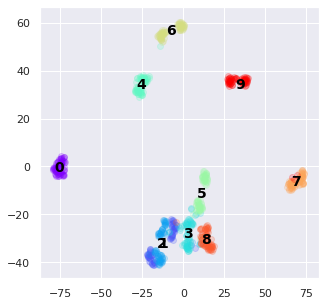

In [10]:
## TSNE法 画散点图
#t-SNE是目前来说效果最好的数据降维与可视化方法，但是它的缺点也很明显，比如：
#占内存大，运行时间长。
#专用于可视化，即嵌入空间只能是2维或3维。
#需要尝试不同的初始化点，以防止局部次优解的影响。

import numpy as np
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('Please install sklearn for layer visualization')

plot_only = len(data.y_test)
x = torch.from_numpy(np.array(data.X_test[0:plot_only], dtype='float32')).cuda()
siamese_net(x,x)
intermediate_tensor = activation['fc1']
# Visualization of trained flatten layer (T-SNE)
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
low_dim_embs = tsne.fit_transform(intermediate_tensor.cpu())
p_data = pd.DataFrame(columns=['x', 'y', 'label'])
p_data.x = low_dim_embs[:, 0]
p_data.y = low_dim_embs[:, 1]
p_data.label = data.y_test[0:plot_only]
utils.plot_with_labels(p_data)        #画散点图
plt.savefig("%s/90-tsne-one-shot.pdf" % (settings["save_path"]))
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


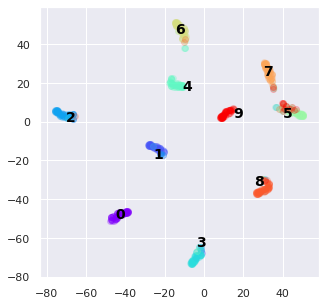

In [11]:
import numpy as np

plot_only = len(data.y_test)
x = torch.from_numpy(np.array(data.X_test[0:plot_only], dtype='float32')).cuda()
wdcnn_net(x)
intermediate_tensor = activation['layer']
# Visualization of trained flatten layer (T-SNE)
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
low_dim_embs = tsne.fit_transform(intermediate_tensor.cpu())
import pandas as pd
p_data = pd.DataFrame(columns=['x', 'y', 'label'])
p_data.x = low_dim_embs[:, 0]
p_data.y = low_dim_embs[:, 1]
p_data.label = data.y_test[0:plot_only]
utils.plot_with_labels(p_data)
plt.savefig("%s/90-tsne-wdcnn.pdf" % (settings["save_path"]))
plt.show()

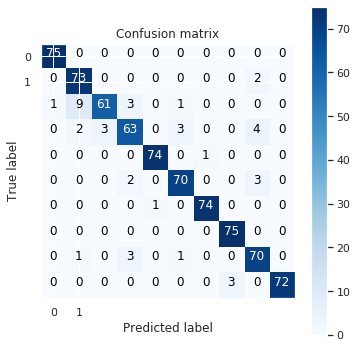

<Figure size 360x360 with 0 Axes>

In [12]:
# 验证一下模型可不可以用
#画混淆矩阵


import itertools
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 用数据集最好的数据画

from sklearn.metrics import f1_score,accuracy_score,confusion_matrix
siamese_loader = SiameseNetworkDataset(X_train, y_train, data.X_test, data.y_test, mode='test')
val_dataloader = DataLoader(siamese_loader, batch_size=1, shuffle=False)
labels = []
predicts = []
for i, batch_data in enumerate(val_dataloader, 0):
    input0, input1, label, label0, label1 = batch_data
    img0, img1, label = input0.cuda(), input1.cuda(), label.cuda()
    img0 = input0.reshape(img0.shape[1:]).cuda()
    img1 = input1.reshape(img1.shape[1:]).cuda()
    output1 = siamese_net(img0, img1)
    predict = np.argmax(output1.cpu().detach().numpy())

    predicts.append(predict)
    labels.append(label0)
# utils.confusion_plot(preds[:,1],preds[:,0])

cm = confusion_matrix(labels,predicts)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm
                    , classes=class_names
                    , title='Confusion matrix')
plt.show()
plt.savefig("%s/90-cm-one-shot.pdf" % (settings["save_path"]))
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


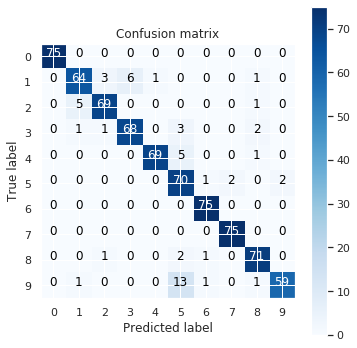

In [13]:
x = torch.from_numpy(np.array(data.X_test, dtype='float32')).cuda()
pred = np.argmax(wdcnn_net(x).cpu().detach().numpy(), axis=1).reshape(-1,1)
# utils.confusion_plot(pred,data.y_test)
plot_confusion_matrix(confusion_matrix(data.y_test,pred)
                        , classes= [0,1,2,3,4,5,6,7,8,9]
                        , title='Confusion matrix')
plt.savefig("%s/90-cm-wdcnn.pdf" % (settings["save_path"]))
plt.show()